# 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

# matplotlib 그래프 속성 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (12,16)
plt.rcParams['font.size'] = 20

# 그래프 그릴 때 마이너스(-) 부분도 표시해주기 (로그오즈비 표현을 위해 세팅)
plt.rcParams['axes.unicode_minus'] = False

# 사용자 정의 함수

In [23]:
# 텍스트 전처리
def prepro_text(raw_data):

    # 특수기호, 영어, 숫자 제거
    prepro_texts = re.sub(r'[^가-힣]',' ',str(raw_data))

    # 형태소 분석기 생성
    okt = Okt()

    # 조사와 복수표현 등 필요없는 품사 tag 제거
    prepro_word = []
    for word, tag in okt.pos(prepro_texts):
        if tag not in ['Josa', 'Suffix']:
            prepro_word.append(word)
    
    # 어간 추출 적용 할 경우
    #result = ' '.join(okt.morphs(' '.join(prepro_word), stem=True))

    # 어간 추출 적용 안할 경우
    result = ' '.join(prepro_word)

    return result


# 빈도분석 후 결과 출력
def count_analyze(texts, count_vec, color, title):
    
    count_vec.fit(texts)
    
    word_dict = sorted(count_vec.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}

    total_text = []
    total_text.append(' '.join(texts.values))

    count_matrix = count_vec.transform(total_text)

    count_word = []
    count_vector = []

    for i in range(10,0,-1):
        count_word.append(idx2word[(-count_matrix.toarray()[0]).argsort()[i-1]])
        count_vector.append(count_matrix.toarray()[0][(-count_matrix.toarray()[0]).argsort()[i-1]])

    print(count_word)
    print(count_vector)

    plt.barh(count_word, count_vector, color=color)
    plt.yticks(count_word)
    plt.title(f'{title} 빈도 분석')
    plt.show()

    return count_word, count_vector


# TF-IDF 생성 함수
def tfidf_analyze(fit_data, analysis_data, vec, color, title):
    vec.fit(fit_data)

    word_dict = sorted(vec.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}

    total_text = []
    total_text.append(' '.join(analysis_data.values))

    matrix = vec.transform(total_text)

    word = []
    vector = []
    if len(matrix.toarray()[0]) >= 5:
        for i in range(5,0,-1):
            word.append(idx2word[matrix.toarray()[0].argsort()[-i]])
            vector.append(matrix.toarray()[0][matrix.toarray()[0].argsort()[-i]])
    else:
        for i in range(len(matrix.toarray()[0]),0,-1):
            word.append(idx2word[matrix.toarray()[0].argsort()[-i]])
            vector.append(matrix.toarray()[0][matrix.toarray()[0].argsort()[-i]])

    print(word)
    print(vector)
    
    #plt.figure(figsize=(12,16))
    plt.barh(word, vector, color=color)
    plt.yticks(word)
    plt.title(f'{title} TF-IDF')
    plt.show()

    return word, vector

    
# 코사인 유사도 문장 매칭
def cosine_sim_matching(vectorizer, fit_text, transform_text, word_list, raw_text, title):
    # 비교할 전체 텍스트 적합
    vectorizer.fit(fit_text)
    rep_df = pd.DataFrame(columns=['선택단어', '대표문장', '코사인유사도'])

    for text in word_list[::-1]:

        # 선택한 단어들 벡터화
        selected_word = pd.Series([text])
        selected_word_vec = vectorizer.transform(selected_word)
        
        # 전체 문장 벡터화
        total_text = vectorizer.transform(transform_text)

        # 코사인 유사도
        cosine_sim = cosine_similarity(selected_word_vec, total_text)

        sim_score = []
        sentence = []
        for i in range(5):
            if cosine_sim[0][cosine_sim[0].argsort()[-(i+1)]] > 0 :
                sim_score.append(cosine_sim[0][cosine_sim[0].argsort()[-(i+1)]])
                sentence.append(raw_text.iloc[cosine_sim[0].argsort()[-(i+1)]])
            else:
                pass
        
        cosine_df = pd.DataFrame({
            '선택단어' : [text] + ([np.nan]*(len(sim_score)-1)),
            '대표문장' : sentence,
            '코사인유사도' : sim_score
        })

        rep_df = rep_df.append(cosine_df, ignore_index=True)

    # csv 파일로 변환할 경우 활성화
    #rep_df.to_csv(f'./{title}.csv', encoding='utf-8-sig')

    return rep_df


# 코사인 유사도 score 추출
def cosine_extraction(vec, fit_data, new_data, count_words, q_title):

    # label1인 데이터로 적합
    vec.fit(fit_data)

    # 빈도분석으로 뽑은 Top10 단어들 하나의 text로
    top10_word_vec = vec.transform([' '.join(count_words)])

    # label1 데이터 백터 변환
    fit_data_vec = vec.transform(fit_data)
    # label0 데이터 백터 변환
    new_data_vec = vec.transform(new_data)

    fit_data_cosine_sim = cosine_similarity(top10_word_vec, fit_data_vec)
    new_data_cosine_sim = cosine_similarity(top10_word_vec, new_data_vec)

    label0_data_name = []
    label1_data_name = []
    for idx0 in new_data.index.values:
        label0_data_name.append(df['성명'][df['index']==idx0].values[0])

    for idx1  in fit_data.index.values:
        label1_data_name.append(df['성명'][df['index']==idx1].values[0])

    fit_cosine_df = pd.DataFrame({
        '성함' : label1_data_name,
        q_title : fit_data_cosine_sim[0]
    })

    new_cosine_df = pd.DataFrame({
        '성함' : label0_data_name,
        q_title : new_data_cosine_sim[0]
    })

    return new_cosine_df, fit_cosine_df


# 1ngram용 코사인 유사도 문장 매칭
def cosine_sim_1ngram(vectorizer, fit_text, transform_text, word_list, raw_text, cnt):
    # 비교할 전체 텍스트 적합
    new_text = []
    new_text.append(' '.join(word_list[::-1]))

    vectorizer.fit(fit_text)
    rep_text = vectorizer.transform(new_text)
    prepro_text = vectorizer.transform(transform_text)

    cosine_1ngram = cosine_similarity(rep_text, prepro_text)

    cosine_score = []
    selected_sentence = []

    for i in range(cnt):
        cosine_score.append(cosine_1ngram[0][cosine_1ngram[0].argsort()[-(i+1)]])
        selected_sentence.append(raw_text.iloc[cosine_1ngram[0].argsort()[-(i+1)]])

    rep_1ngram_df = pd.DataFrame({
        f"'{new_text[0]}' → 대표문장" : selected_sentence,
        '코사인유사도' : cosine_score
    })

    return rep_1ngram_df


# 로그 오즈비 구하기
def log_odds_ratio(count_vec, prepro_data1, prepro_data2, count_word1, count_word2, title):

    # 빈도분석으로 뽑은 단어들 공통 단어 빼고, 유일한 단어들로 정리
    count_word_list = list(set(count_word1 + count_word2))

    #################################################################
    # 첫 번째 (기준 데이터)
    # 기준으로 정한 데이터로 다시 적합시키기
    count_vec.fit(prepro_data1)

    # 우리가 원하는 빈도 수치 뽑기 위한 데이터 정리
    join_text1 = []
    join_text1.append(' '.join(prepro_data1.values))

    # 빈도 뽑아내기
    count_transform1 = count_vec.transform(join_text1)

    # 단어사전 만들기
    word2idx1 = {word:idx for word, idx in count_vec.vocabulary_.items()}

    # 첫번째 데이터에 대한 확인 할 단어 빈도 수치 뽑기
    text_vector1 = []
    for word in count_word_list:
      if word in word2idx1.keys():
        text_vector1.append(count_transform1.toarray()[0][word2idx1[word]])
      else:
        text_vector1.append(0)

    #################################################################

    # 두 번째 (비교 데이터)
    # 다시 적합시키기
    count_vec.fit(prepro_data2)

    # 우리가 원하는 빈도 수치 뽑기 위한 데이터 정리
    join_text2 = []
    join_text2.append(' '.join(prepro_data2.values))

    # 빈도 뽑아내기
    count_transform2 = count_vec.transform(join_text2)

    # 단어사전 만들기
    word2idx2 = {word:idx for word, idx in count_vec.vocabulary_.items()}

    # 두번째 데이터에 대한 확인 할 단어 빈도 수치 뽑기
    text_vector2 = []
    for word in count_word_list:
      if word in word2idx2.keys():
        text_vector2.append(count_transform2.toarray()[0][word2idx2[word]])
      else:
        text_vector2.append(int(0))

    #################################################################

    # 빈도 수치 데이터 프레임 만들기
    count_df = pd.DataFrame({
        'word' : count_word_list,
        'data1' : text_vector1,
        'data2' : text_vector2
    })

    # count_df.sort_values(by='data1', axis=0, ascending=False, inplace=True)
    count_df['odds1'] = (count_df['data1']/sum(count_df['data1'])) / (1 - (count_df['data1']/sum(count_df['data1']))) # 기준데이터 odds 구하기
    count_df['odds2'] = (count_df['data2']/sum(count_df['data2'])) / (1 - (count_df['data2']/sum(count_df['data2']))) # 비교데이터 odds 구하기
    count_df['odds_ratio'] = count_df['odds1'] / count_df['odds2']  # ==> 오즈비 구하기
    count_df['log_odds_ratio'] = np.log(count_df['odds_ratio'])     # ==> 로그 오즈비 구하기
    count_df.sort_values(by='log_odds_ratio', ascending=False, inplace=True)  # ==> 로그 오즈비 기준으로 내림차순 정렬하기
    count_df['positive'] = count_df['log_odds_ratio'] > 0

    # 무한대값은 제거하자
    count_df = count_df[(count_df['log_odds_ratio'] != np.inf) & (count_df['log_odds_ratio'] != -np.inf)]

    plt.barh(count_df['word'].values[::-1], count_df['log_odds_ratio'].values[::-1], color=count_df['positive'][::-1].map({True:'skyblue', False:'lightpink'}))
    plt.title(f'{title} 로그오즈비 비교')
    plt.yticks(count_df['word'].values[::-1])
    plt.show()

    return count_df

# 데이터 로드

In [21]:
pd.set_option('max_rows', 8)

In [4]:
df = pd.read_excel('./211103_히든그레이스_인재예측모델링용_데이터(대표님 수정).xlsx')
df['index'] = df.index
df

,성명,생년월일,만 나이,성별,결혼유무,장애정도(경증/중증),장애유형,학력,인턴활동여부,대외활동여부,...,업무강점,성장과정,성격의 장점,성격의 단점,지원동기 및 입사 후 포부,히든그레이스는 어떤 회사인가,히든그레이스가 보완할 점,"채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소",고린도전서 읽은 후 기술,index
0,오탁근,1992.04.06,29,0,0,2,1,3,1,1,...,저는 업무를 하는 데에 있어서 꼼꼼하게 일처리하는 것을 선호하며 실제로도 업무 처리...,생후 불과 몇 개월만에 뇌수막염을 앓게 되어 청각장애라는 불편함을 갖게 되었지만 청...,앞서 업무강점에서 말씀드렸다싶이 저는 꼼꼼함이 강점입니다. 남들이 보지 못한 문제점...,집단에서의 의사결정 능력은 기획서나 교과서 같은 가이드라인이 존재하지 않으면 결정을...,지원하게 된 동기는 귀사에서 논문 분석과 머신러닝 프로젝트를 진행하고 있고 이 부분...,재작년에 진행했던 장애청년드림팀을 통해 다양한 장애를 가진 팀원들을 만나보고 느낀 ...,"히든그레이스에서 논문리뷰와 검증, 통계 교육 등 유의미한 결과물이 정말로 많은데 그...",아직 채용이 되지 않았고 일해보지 않아서 단정 짓기 어렵지만 명시된 계약기간인 6개...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,김혜진,1986.10.24,35,1,0,1,1,3,0,0,...,0,"어릴 적부터 부모님께서 하신 말씀은 절대 놓치지 않았던 노하우는 “언어, 가르침”이...",디자인 업무에 맞춰 하루 8시간 이상 작업을 하며 꼼꼼하게 관리를 지켜냈습니다. 정...,0,많은 도움만 받으며 성장한 장애인에게 스스로 일을 해서 돈 번다는 것은 매우 특별...,인터넷 검색하고 난 후 이제야 알아챘습니다. 알고 보니 박사 석사과정 학위에 관련된...,반드시 보안해야 할 점은 청각장애로서 문의 전화 상담이라는 게 그런 전화통화를 안됩...,청각장애로서 저를 채용이 된다면 아주 오래도록 일을 하고 싶습니다. 이런 저를 뽑아...,0,76


# 데이터 분리

## 우수인재 vs 비우수인재

In [ ]:
# label2 로 확인
# label2 == 0 인 경우 (총 63)

# 지원동기 및 입사 후 포부
q1 = df['지원동기 및 입사 후 포부'][df['label2']==0]
q1 = q1[q1!=0]
print(len(q1)) # ==> 50

# 히든그레이스는 어떤 회사인가
q2 = df['히든그레이스는 어떤 회사인가'][df['label2']==0]
q2 = q2[q2!=0]
print(len(q2)) # ==> 23

# 히든그레이스가 보완할 점
q3 = df['히든그레이스가 보완할 점'][df['label2']==0]
q3 = q3[q3!=0]
print(len(q3)) # ==> 23

# 채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소
q4 = df['채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소'][df['label2']==0]
q4 = q4[q4!=0]
print(len(q4)) # ==> 21

# 고린도전서 읽은 후 기술
q5 = df['고린도전서 읽은 후 기술'][df['label2']==0]
q5 = q5[q5!=0]
print(len(q5)) # ==> 8

##################################################################################

# label2 로 확인
# label2 == 1 인 경우 (총 63)

# 지원동기 및 입사 후 포부
q1_1 = df['지원동기 및 입사 후 포부'][df['label2']==1]
print(len(q1_1))
q1_1 = q1_1[q1_1!=0]
print(len(q1_1)) # ==> 14

# 히든그레이스는 어떤 회사인가
q2_1 = df['히든그레이스는 어떤 회사인가'][df['label2']==1]
q2_1 = q2_1[q2_1!=0]
print(len(q2_1)) # ==> 14

# 히든그레이스가 보완할 점
q3_1 = df['히든그레이스가 보완할 점'][df['label2']==1]
q3_1 = q3_1[q3_1!=0]
print(len(q3_1)) # ==> 14

# 채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소
q4_1 = df['채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소'][df['label2']==1]
q4_1 = q4_1[q4_1!=0]
print(len(q4_1)) # ==> 14

# 고린도전서 읽은 후 기술
q5_1 = df['고린도전서 읽은 후 기술'][df['label2']==1]
q5_1 = q5_1[q5_1!=0]
print(len(q5_1)) # ==> 12

## 채용 vs 미채용

In [ ]:
# 미채용
# label3 == 0

# 지원동기 및 입사 후 포부
nonjob_q1 = df['지원동기 및 입사 후 포부'][df['label3']==0]
nonjob_q1 = nonjob_q1[nonjob_q1!=0]
print(len(nonjob_q1)) # ==> 40

# 히든그레이스는 어떤 회사인가
nonjob_q2 = df['히든그레이스는 어떤 회사인가'][df['label3']==0]
nonjob_q2 = nonjob_q2[nonjob_q2!=0]
print(len(nonjob_q2)) # ==> 13

# 히든그레이스가 보완할 점
nonjob_q3 = df['히든그레이스가 보완할 점'][df['label3']==0]
nonjob_q3 = nonjob_q3[nonjob_q3!=0]
print(len(nonjob_q3)) # ==> 13

# 채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소
nonjob_q4 = df['채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소'][df['label3']==0]
nonjob_q4 = nonjob_q4[nonjob_q4!=0]
print(len(nonjob_q4)) # ==> 13

# 고린도전서 읽은 후 기술
nonjob_q5 = df['고린도전서 읽은 후 기술'][df['label3']==0]
nonjob_q5 = nonjob_q5[nonjob_q5!=0]
print(len(nonjob_q5)) # ==> 0

#########################################

# 채용
# label3 == 1
# 지원동기 및 입사 후 포부
getjob_q1_1 = df['지원동기 및 입사 후 포부'][df['label3']==1]
getjob_q1_1 = getjob_q1_1[getjob_q1_1!=0]
print(len(getjob_q1_1)) # ==> 24

# 히든그레이스는 어떤 회사인가
getjob_q2_1 = df['히든그레이스는 어떤 회사인가'][df['label3']==1]
getjob_q2_1 = getjob_q2_1[getjob_q2_1!=0]
print(len(getjob_q2_1)) # ==> 24

# 히든그레이스가 보완할 점
getjob_q3_1 = df['히든그레이스가 보완할 점'][df['label3']==1]
getjob_q3_1 = getjob_q3_1[getjob_q3_1!=0]
print(len(getjob_q3_1)) # ==> 24

# 채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소
getjob_q4_1 = df['채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소'][df['label3']==1]
getjob_q4_1 = getjob_q4_1[getjob_q4_1!=0]
print(len(getjob_q4_1)) # ==> 22

# 고린도전서 읽은 후 기술
getjob_q5_1 = df['고린도전서 읽은 후 기술'][df['label3']==1]
getjob_q5_1 = getjob_q5_1[getjob_q5_1!=0]
print(len(getjob_q5_1)) # ==> 20

# 데이터 전처리

In [7]:
# 우수인재 vs 비우수인재
# label이 0인 데이터
prepro_q1 = q1.map(prepro_text)
prepro_q2 = q2.map(prepro_text)
prepro_q3 = q3.map(prepro_text)
prepro_q4 = q4.map(prepro_text)
prepro_q5 = q5.map(prepro_text)

# label이 1인 데이터
prepro_q1_1 = q1_1.map(prepro_text)
prepro_q2_1 = q2_1.map(prepro_text)
prepro_q3_1 = q3_1.map(prepro_text)
prepro_q4_1 = q4_1.map(prepro_text)
prepro_q5_1 = q5_1.map(prepro_text)

# 채용 vs 미채용
# label이 0인 데이터
prepro_nonjob_q1 = nonjob_q1.map(prepro_text)
prepro_nonjob_q2 = nonjob_q2.map(prepro_text)
prepro_nonjob_q3 = nonjob_q3.map(prepro_text)
prepro_nonjob_q4 = nonjob_q4.map(prepro_text)
#prepro_nonjob_q5 = nonjob_q5.map(prepro_text)

# label이 1인 데이터
prepro_getjob_q1 = getjob_q1_1.map(prepro_text)
prepro_getjob_q2 = getjob_q2_1.map(prepro_text)
prepro_getjob_q3 = getjob_q3_1.map(prepro_text)
prepro_getjob_q4 = getjob_q4_1.map(prepro_text)
prepro_getjob_q5 = getjob_q5_1.map(prepro_text)

## label0

In [8]:
stop_words0 = ['하는', '생각', '업무', '있는', '하여', '회사', '합니다', '하게', '지원', '하다', '있다',
               '되다', '되어다', '싶다', '이다', '입사', '자다', '위해', '않다', '가지', '많다', '보다',
               '귀사', '관련', '같다', '느끼다', '아니다', '히든', '그레이스', '오래', '근무', '문제', '정도', '분야',
               '통해', '채용', '요소', '어떻다', '만약', '때문', '그렇다', '하지만', '좋다', '일이']
count_vec0 = CountVectorizer(
    stop_words=stop_words0,
    max_features=20,
    min_df=1
)

['발전', '컴퓨터', '경험', '필요하다', '사회', '능력', '최선', '배우다', '노력', '사람']
[18, 18, 19, 19, 22, 24, 27, 30, 30, 40]


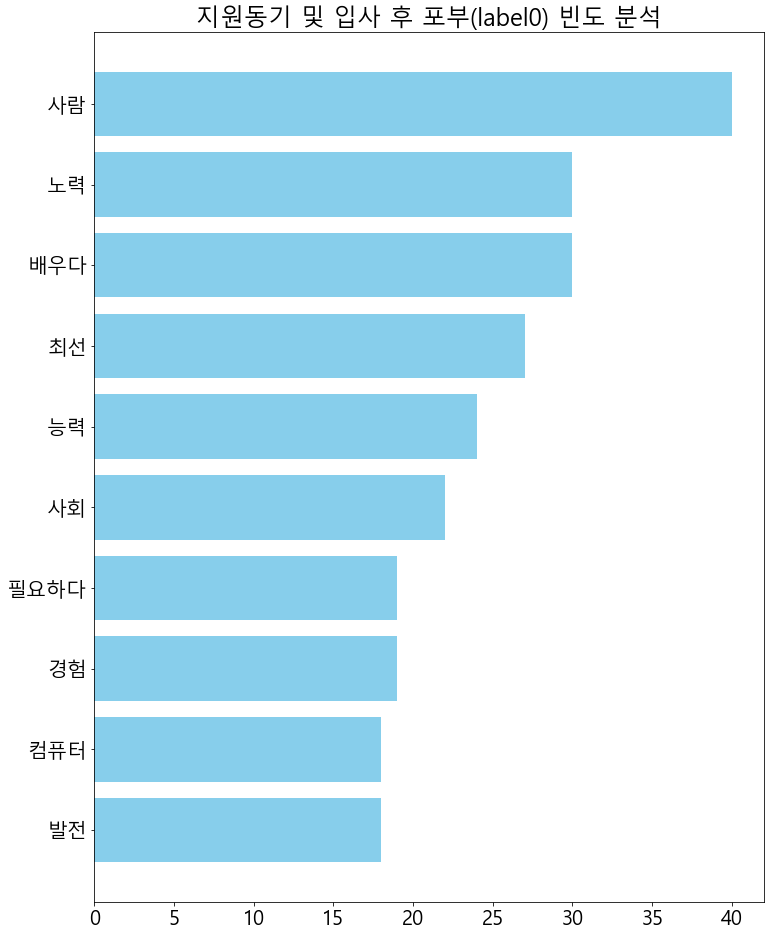

['주다', '취약', '분석', '도움', '계층', '데이터', '사람', '기업', '사회', '논문']
[9, 10, 10, 11, 11, 12, 13, 21, 23, 36]


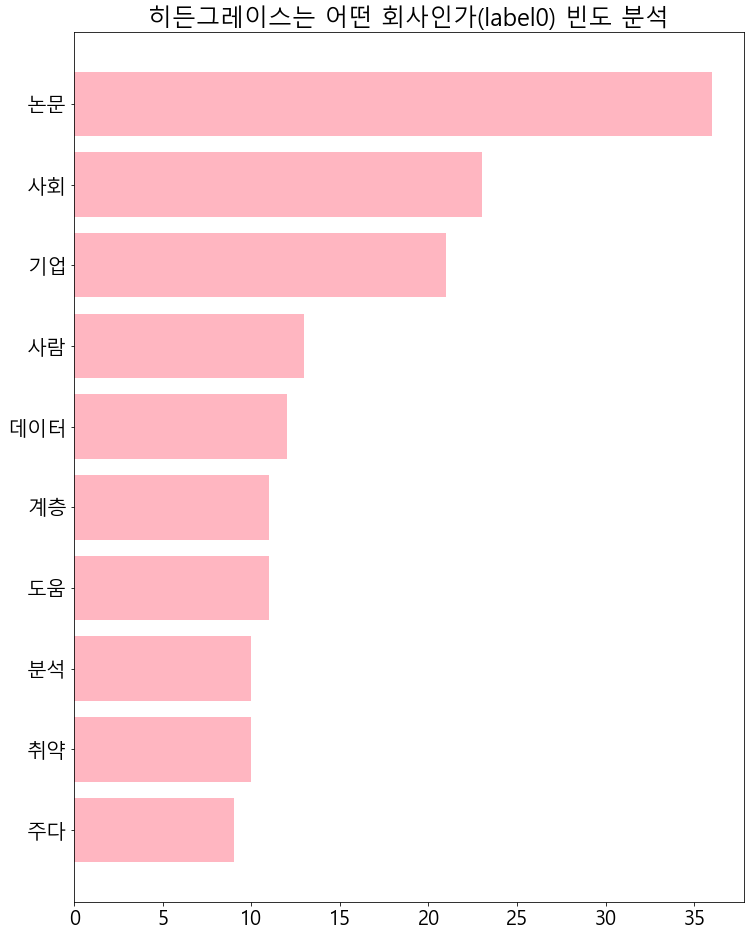

['없다', '보완', '찾다', '함께', '통계', '홍보', '자료', '분석', '데이터', '논문']
[8, 8, 8, 9, 9, 9, 10, 10, 10, 28]


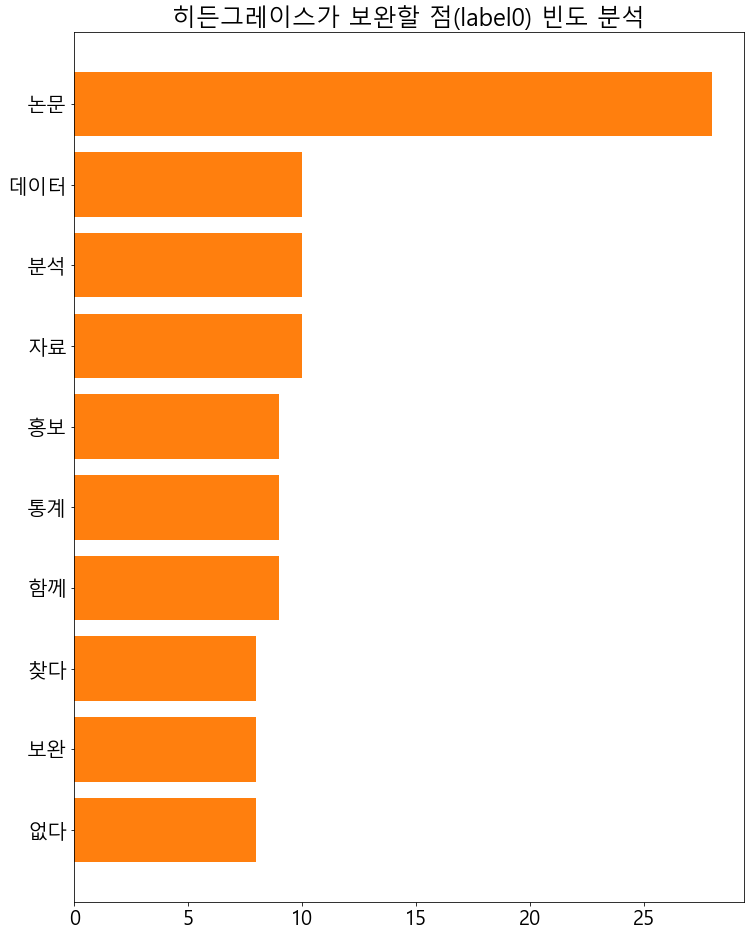

['이루어지다', '중요하다', '최대한', '크다', '장기', '발전', '개인', '함께', '사람', '없다']
[3, 3, 3, 3, 4, 4, 4, 5, 12, 19]


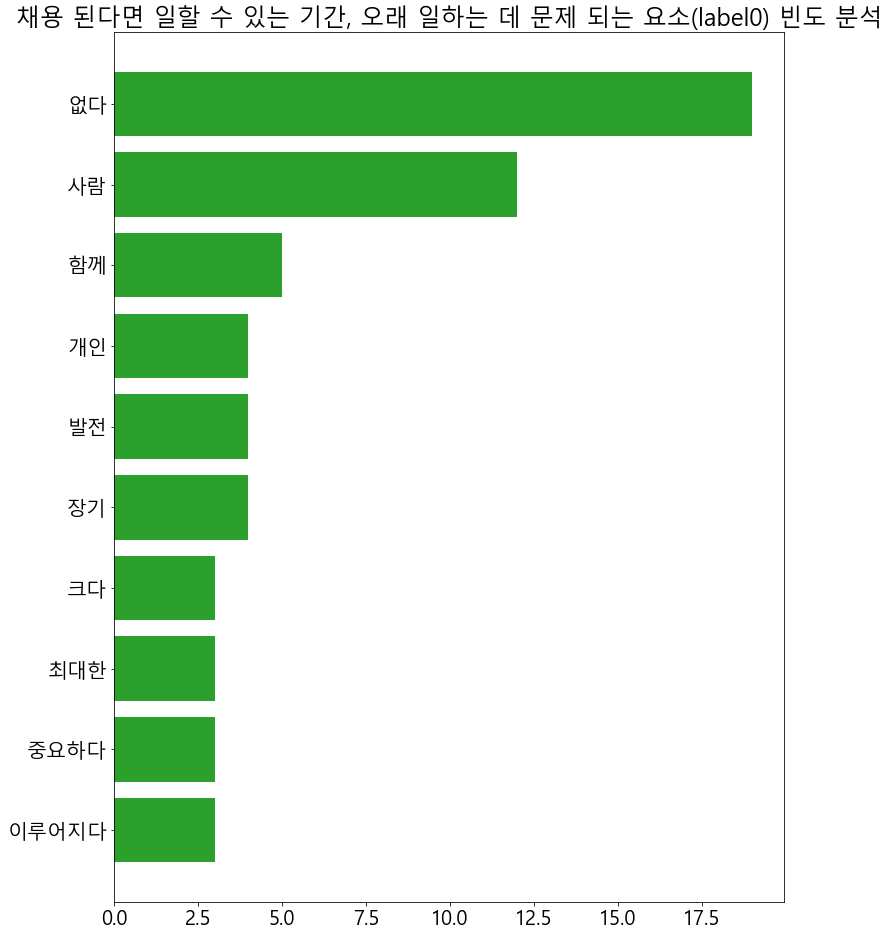

['세상', '사회', '믿다', '모두', '숨기다', '자신', '우리', '낮다', '하나님', '사람']
[4, 4, 4, 4, 4, 5, 6, 6, 11, 14]


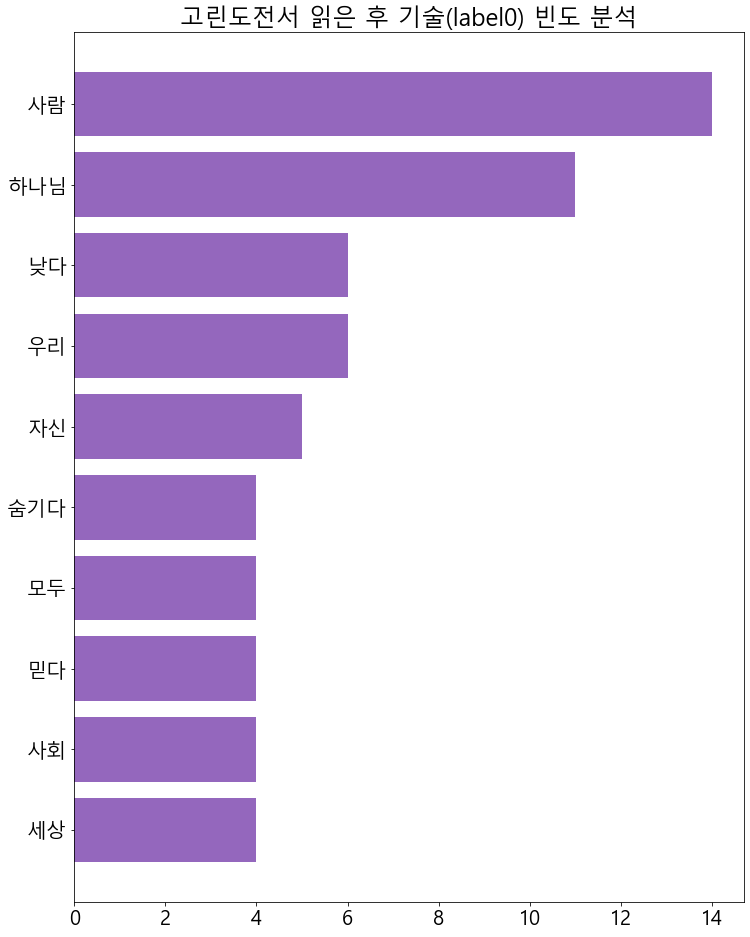

In [9]:
word_q1 , countvec_q1 = count_analyze(prepro_q1, count_vec0, 'skyblue', '지원동기 및 입사 후 포부(label0)')
word_q2 , countvec_q2 = count_analyze(prepro_q2, count_vec0, 'lightpink', '히든그레이스는 어떤 회사인가(label0)')
word_q3 , countvec_q3 = count_analyze(prepro_q3, count_vec0, 'tab:orange', '히든그레이스가 보완할 점(label0)')
word_q4 , countvec_q4 = count_analyze(prepro_q4, count_vec0, 'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소(label0)')
word_q5 , countvec_q5 = count_analyze(prepro_q5, count_vec0, 'tab:purple', '고린도전서 읽은 후 기술(label0)')

## label1

In [10]:
stop_words1 = ['하는', '생각', '업무', '있는', '하여', '회사', '합니다', '하게', '지원', '하다', '있다',
               '되다', '되어다', '싶다', '이다', '입사', '자다', '위해', '않다', '가지', '많다', '보다',
               '귀사', '관련', '같다', '느끼다', '아니다', '히든', '그레이스', '오래', '근무', '문제', '정도', '분야',
               '통해', '채용', '요소', '어떻다', '만약', '때문', '그렇다', '하지만', '좋다', '일이', '인하다']
count_vec1 = CountVectorizer(
    stop_words=stop_words0,
    max_features=20,
    min_df=1
)

['고객', '역량', '사람', '기업', '경험', '개발', '데이터', '통계', '사회', '분석']
[7, 8, 9, 11, 12, 12, 15, 19, 21, 24]


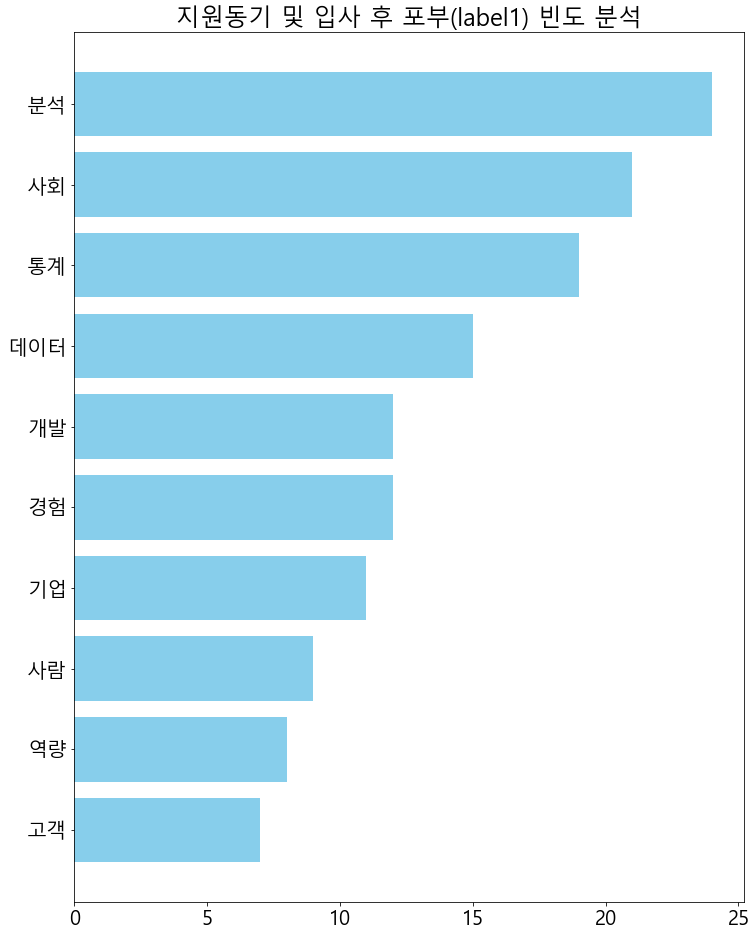

['재능', '전문가', '직원', '분석', '사람', '취약', '논문', '계층', '기업', '사회']
[6, 6, 6, 7, 9, 12, 12, 12, 15, 20]


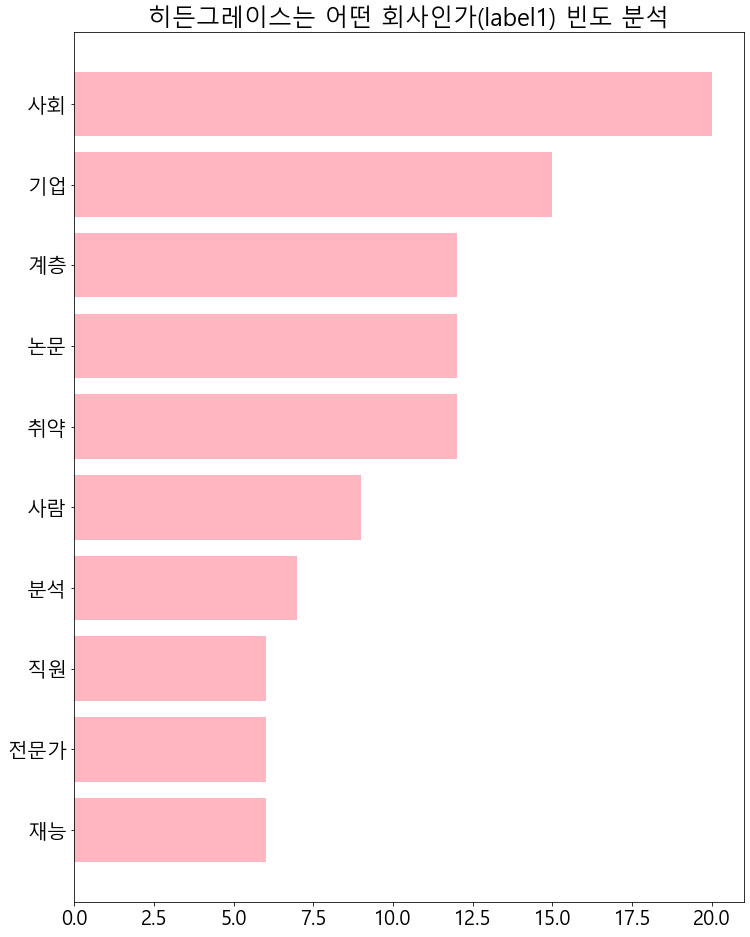

['사람', '취약', '부분', '기업', '받다', '대상', '분석', '논문', '계열', '진행']
[6, 6, 6, 6, 7, 8, 10, 11, 11, 12]


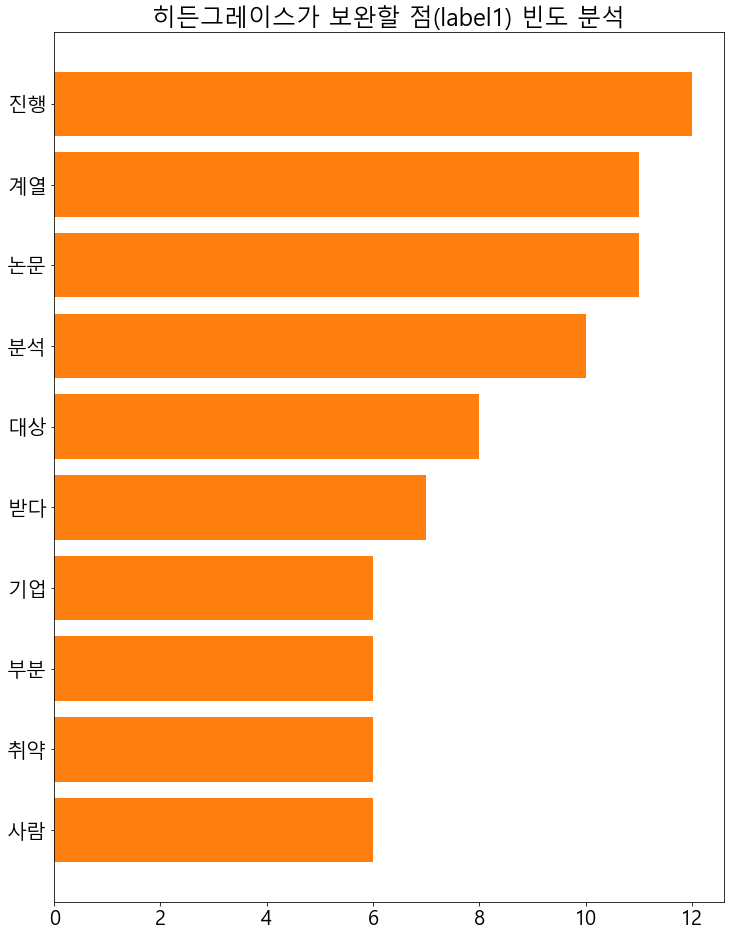

['사람', '가능하다', '서로', '이상', '인하다', '임금', '직장', '중요하다', '없다', '함께']
[4, 4, 4, 4, 4, 4, 4, 5, 6, 7]


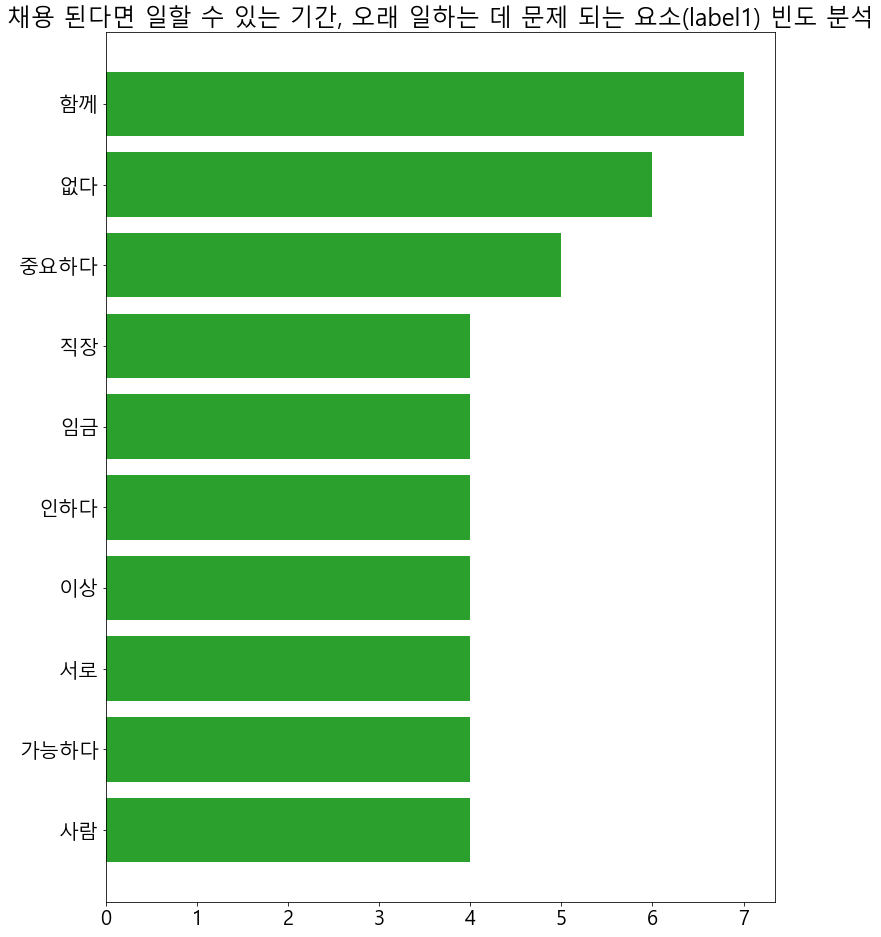

['우리', '특별하다', '의미', '능력', '없다', '약하다', '지혜', '세상', '하나님', '사람']
[7, 7, 8, 8, 9, 10, 11, 18, 28, 37]


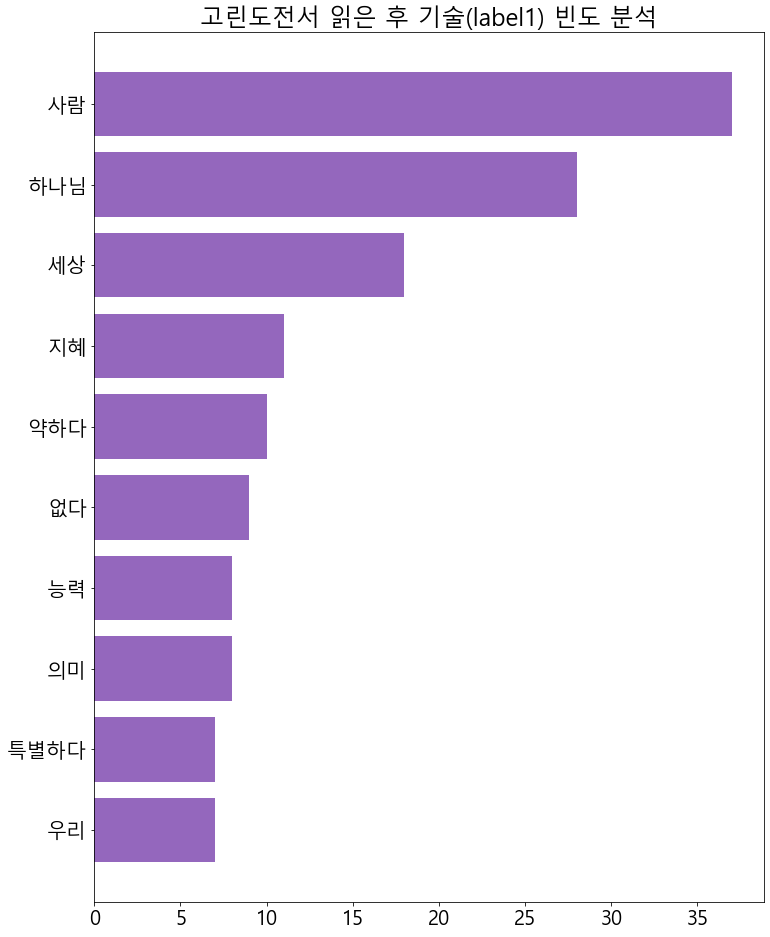

In [11]:
word_q1_1 , countvec_q1_1 = count_analyze(prepro_q1_1, count_vec1, 'skyblue', '지원동기 및 입사 후 포부(label1)')
word_q2_1 , countvec_q2_1 = count_analyze(prepro_q2_1, count_vec1, 'lightpink', '히든그레이스는 어떤 회사인가(label1)')
word_q3_1 , countvec_q3_1 = count_analyze(prepro_q3_1, count_vec1, 'tab:orange', '히든그레이스가 보완할 점(label1)')
word_q4_1 , countvec_q4_1 = count_analyze(prepro_q4_1, count_vec1, 'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소(label1)')
word_q5_1 , countvec_q5_1 = count_analyze(prepro_q5_1, count_vec1, 'tab:purple', '고린도전서 읽은 후 기술(label1)')

In [41]:
q1_label0, q1_label1 = cosine_extraction(count_vec1, prepro_q1_1, prepro_q1, word_q1_1, '지원동기 및 입사 후 포부')
q2_label0, q2_label1 = cosine_extraction(count_vec1, prepro_q2_1, prepro_q2, word_q2_1, '히든그레이스는 어떤 회사인가')
q3_label0, q3_label1 = cosine_extraction(count_vec1, prepro_q3_1, prepro_q2, word_q3_1, '히든그레이스가 보완할 점')
q4_label0, q4_label1 = cosine_extraction(count_vec1, prepro_q4_1, prepro_q3, word_q4_1, '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
q5_label0, q5_label1 = cosine_extraction(count_vec1, prepro_q5_1, prepro_q4, word_q5_1, '고린도전서 읽은 후 기술')

# label0 데이터 정리
label0_df = pd.merge(q2_label0, q1_label0, on='성함', how='outer')
label0_df = pd.merge(q3_label0, label0_df, on='성함', how='outer')
label0_df = pd.merge(q4_label0, label0_df, on='성함', how='outer')
label0_df = pd.merge(q5_label0, label0_df, on='성함', how='outer')
label0_df = label0_df.iloc[:,[0,5,4,3,2,1]]
label0_df['평균'] = label0_df.mean(axis=1)
label0_df.sort_values(by='평균', ascending=False, inplace=True)

# label1 데이터 정리
label1_df = pd.merge(q2_label1, q1_label1, on='성함', how='outer')
label1_df = pd.merge(q3_label1, label1_df, on='성함', how='outer')
label1_df = pd.merge(q4_label1, label1_df, on='성함', how='outer')
label1_df = pd.merge(q5_label1, label1_df, on='성함', how='outer')
label1_df = label1_df.iloc[:,[0,5,4,3,2,1]]
label1_df['평균'] = label1_df.mean(axis=1)
label1_df.sort_values(by='평균', ascending=False, inplace=True)


In [53]:
# csv 파일 변환
label0_df.to_csv('./히든그레이스 자소서 코사인 유사도 (label0).csv', encoding='utf-8-sig', index=False)
label1_df.to_csv('./히든그레이스 자소서 코사인 유사도 (label1).csv', encoding='utf-8-sig', index=False)

## label0

In [ ]:
# 지원동기 및 입사 후 포부
cosine_sim_matching(count_vec0, prepro_q1, word_q1, q1, 5)

In [ ]:
# 히든그레이스는 어떤 회사인가
cosine_sim_matching(count_vec0, prepro_q2, word_q2, q2, 5)

In [ ]:
# 히든그레이스가 보완할 점
cosine_sim_matching(count_vec0, prepro_q3, word_q3, q3, 5)

In [ ]:
# 채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소
cosine_sim_matching(count_vec0, prepro_q4, word_q4, q4, 5)

In [ ]:
# 고린도전서 읽은 후 기술
cosine_sim_matching(count_vec0, prepro_q5, word_q5, q5, 5)

## label1

In [ ]:
# 지원동기 및 입사 후 포부
cosine_sim_matching(count_vec1, prepro_q1_1, word_q1_1, q1_1, 5)

In [ ]:
# 히든그레이스는 어떤 회사인가
cosine_sim_matching(count_vec1, prepro_q2_1, word_q2_1, q2_1, 5)

In [ ]:
# 히든그레이스가 보완할 점
cosine_sim_matching(count_vec1, prepro_q3_1, word_q3_1, q3_1, 5)

In [ ]:
# 채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소
cosine_sim_matching(count_vec1, prepro_q4_1, word_q4_1, q4_1, 5)

In [ ]:
# 고린도전서 읽은 후 기술
cosine_sim_matching(count_vec1, prepro_q5_1, word_q5_1, q5_1, 5)

# 로그오즈비

## 우수인재 vs 비우수인재

In [ ]:
# 전용 불용어 사전
stop_words_woosu = ['하는', '있는', '하여', '합니다', '하게', '지원', '입니다', '입사', '하겠습니다', '위해', '되었습니다', '싶습니다', '가지', '생각', '통해',
                                   '회사', '히든', '그레이스', '분야', '해야', '같습니다', '관련', '오래', '하는데', '요소', '되는', '된다면', '있습니다', '하지', '정도', '하고',
                                   '있을', '만약', '어떤', '때문', '있다고']

# CountVectorizer for Log odds ratio
count_woosu = CountVectorizer(
    #max_features = 50
    #min_df = 10
    stop_words = stop_words_woosu
)

In [ ]:
# 비우수인재 count vec
nongood_q1_word, nongood_q1_vec = count_analyze(prepro_q1, count_woosu, 'tab:blue', '지원동기 및 입사 후 포부')
nongood_q2_word, nongood_q2_vec = count_analyze(prepro_q2, count_woosu, 'tab:red', '히든그레이스는 어떤 회사인가')
nongood_q3_word, nongood_q3_vec = count_analyze(prepro_q3, count_woosu, 'tab:orange', '히든그레이스가 보완할 점')
nongood_q4_word, nongood_q4_vec = count_analyze(prepro_q4, count_woosu, 'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
nongood_q5_word, nongood_q5_vec = count_analyze(prepro_q5, count_woosu, 'tab:purple', '고린도전서 읽은 후 기술')

# 우수인재 count vec
good_q1_word, good_q1_vec = count_analyze(prepro_q1_1, count_woosu, 'tab:blue', '지원동기 및 입사 후 포부')
good_q2_word, good_q2_vec = count_analyze(prepro_q2_1, count_woosu, 'tab:red', '히든그레이스는 어떤 회사인가')
good_q3_word, good_q3_vec = count_analyze(prepro_q3_1, count_woosu, 'tab:orange', '히든그레이스가 보완할 점')
good_q4_word, good_q4_vec = count_analyze(prepro_q4_1, count_woosu, 'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
good_q5_word, good_q5_vec = count_analyze(prepro_q5_1, count_woosu, 'tab:purple', '고린도전서 읽은 후 기술')

In [ ]:
# 각 질문별 로그오즈비 
q1_logodds_df = log_odds_ratio(count_woosu, prepro_q1_1, prepro_q1, good_q1_word, nongood_q1_word, '지원동기 및 입사 후 포부_우수인재')
q2_logodds_df = log_odds_ratio(count_woosu, prepro_q2_1, prepro_q2, good_q2_word, nongood_q2_word, '히든그레이스는 어떤 회사인가_우수인재')
q3_logodds_df = log_odds_ratio(count_woosu, prepro_q3_1, prepro_q3, good_q3_word, nongood_q3_word, '히든그레이스가 보완할 점_우수인재')
q4_logodds_df = log_odds_ratio(count_woosu, prepro_q4_1, prepro_q4, good_q4_word, nongood_q4_word, '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소_우수인재')
q5_logodds_df = log_odds_ratio(count_woosu, prepro_q5_1, prepro_q5, good_q5_word, nongood_q5_word, '고린도전서 읽은 후 기술_우수인재')

## 채용 vs 미채용

In [ ]:
# 전용 불용어 사전
stop_words_getjob = ['하는', '있는', '하여', '합니다', '하게', '지원', '입니다', '입사', '하겠습니다', '위해', '되었습니다', '싶습니다', '가지', '생각', '통해',
                                   '회사', '히든', '그레이스', '분야', '해야', '같습니다', '관련', '오래', '하는데', '요소', '되는', '된다면', '있습니다', '하지', '정도', '하고',
                                   '있을', '만약', '어떤', '때문', '있다고', '되어', '대한', '가장', '하였습니다', '실제', '보완', '부분']

# CountVectorizer for Log odds ratio
count_getjob = CountVectorizer(
    #max_features = 50
    #min_df = 10
    stop_words = stop_words_getjob
)

In [ ]:
# 미채용 count vec
nonjob_q1_word, nonjob_q1_vec = count_analyze(prepro_nonjob_q1, count_getjob, 'tab:blue', '지원동기 및 입사 후 포부')
nonjob_q2_word, nonjob_q2_vec = count_analyze(prepro_nonjob_q2, count_getjob, 'tab:red', '히든그레이스는 어떤 회사인가')
nonjob_q3_word, nonjob_q3_vec = count_analyze(prepro_nonjob_q3, count_getjob, 'tab:orange', '히든그레이스가 보완할 점')
nonjob_q4_word, nonjob_q4_vec = count_analyze(prepro_nonjob_q4, count_getjob, 'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
#nonjob_q5_word, nonjob_q5_vec = count_analyze(prepro_nonjob_q5, count_getjob, 'tab:purple', '고린도전서 읽은 후 기술')

# 채용 count vec
getjob_q1_word, getjob_q1_vec = count_analyze(prepro_getjob_q1, count_getjob, 'tab:blue', '지원동기 및 입사 후 포부')
getjob_q2_word, getjob_q2_vec = count_analyze(prepro_getjob_q2, count_getjob, 'tab:red', '히든그레이스는 어떤 회사인가')
getjob_q3_word, getjob_q3_vec = count_analyze(prepro_getjob_q3, count_getjob, 'tab:orange', '히든그레이스가 보완할 점')
getjob_q4_word, getjob_q4_vec = count_analyze(prepro_getjob_q4, count_getjob, 'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
#getjob_q5_word, getjob_q5_vec = count_analyze(prepro_nonjob_q5, count_getjob, 'tab:purple', '고린도전서 읽은 후 기술')

In [ ]:
# 각 질문별 로그오즈비 
q1_job_df = log_odds_ratio(count_getjob, prepro_getjob_q1, prepro_nonjob_q1, getjob_q1_word, nonjob_q1_word, '지원동기 및 입사 후 포부_우수인재')
q2_job_df = log_odds_ratio(count_getjob, prepro_getjob_q2, prepro_nonjob_q2, getjob_q2_word, nonjob_q2_word, '히든그레이스는 어떤 회사인가_우수인재')
q3_job_df = log_odds_ratio(count_getjob, prepro_getjob_q3, prepro_nonjob_q3, getjob_q3_word, nonjob_q3_word, '히든그레이스가 보완할 점_우수인재')
q4_job_df = log_odds_ratio(count_getjob, prepro_getjob_q4, prepro_nonjob_q4, getjob_q4_word, nonjob_q4_word, '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소_우수인재')
# q5_job_df = log_odds_ratio(count_woosu, prepro_q5_1, prepro_q5, good_q5_word, nongood_q5_word, '고린도전서 읽은 후 기술_우수인재')

# TF-IDF(3_ngram) & 코사인 유사도 매칭 문장

## 우수인재 vs 비우수인재

In [ ]:
# 불용어 사전
stop_words_1 = ['지원', '되었습니다', '있다고', '합니다', '하게', '하는', '된다면', '싶습니다', '생각', '오래', '하는데', '문제', '요소', '만약', '히든', '그레이스',
                         '하지', '않고', '보완', '해야', '있을', '같습니다', '하여', '되는', '있기', '때문', '가지', '싶은', '있는', '있습니다', '이상']

# tfidf
tfidf_woosu = TfidfVectorizer(
    stop_words = stop_words_1,
    ngram_range = (2,2),
    min_df = 2
)

In [ ]:
# 비우수 인재
non_q1_word, non_q1_tfidf = tfidf_analyze(prepro_q1, prepro_q1, tfidf_woosu,'tab:blue', '지원동기 및 입사 후 포부')
non_q2_word, non_q2_tfidf = tfidf_analyze(prepro_q2, prepro_q2, tfidf_woosu,'tab:red', '히든그레이스는 어떤 회사인가')
non_q3_word, non_q3_tfidf = tfidf_analyze(prepro_q3, prepro_q3, tfidf_woosu,'tab:orange', '히든그레이스가 보완할 점')
non_q4_word, non_q4_tfidf = tfidf_analyze(prepro_q4, prepro_q4, tfidf_woosu,'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
non_q5_word, non_q5_tfidf = tfidf_analyze(prepro_q5, prepro_q5, tfidf_woosu,'tab:purple', '고린도전서 읽은 후 기술')

# 우수 인재(1)
great_q1_word, great_q1_tfidf = tfidf_analyze(prepro_q1_1, prepro_q1_1, tfidf_woosu,'tab:blue', '지원동기 및 입사 후 포부')
great_q2_word, great_q2_tfidf = tfidf_analyze(prepro_q2_1, prepro_q2_1, tfidf_woosu,'tab:red', '히든그레이스는 어떤 회사인가')
great_q3_word, great_q3_tfidf = tfidf_analyze(prepro_q3_1, prepro_q3_1, tfidf_woosu,'tab:orange', '히든그레이스가 보완할 점')
great_q4_word, great_q4_tfidf = tfidf_analyze(prepro_q4_1, prepro_q4_1, tfidf_woosu,'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
great_q5_word, great_q5_tfidf = tfidf_analyze(prepro_q5_1, prepro_q5_1, tfidf_woosu,'tab:purple', '고린도전서 읽은 후 기술')

In [ ]:
# 비우수인재 코사인 유사도 문장
non_q1_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q1, prepro_q1, non_q1_word, q1, '비우수인재_q1')
non_q2_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q2, prepro_q2, non_q2_word, q2, '비우수인재_q2')
non_q3_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q3, prepro_q3, non_q3_word, q3, '비우수인재_q3')
non_q4_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q4, prepro_q4, non_q4_word, q4, '비우수인재_q4')
non_q5_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q5, prepro_q5, non_q5_word, q5, '비우수인재_q5')

# 우수인재 코사인 유사도 문장
great_q1_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q1_1, prepro_q1_1, great_q1_word, q1_1, '우수인재_q1')
great_q2_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q2_1, prepro_q2_1, great_q2_word, q2_1, '우수인재_q2')
great_q3_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q3_1, prepro_q3_1, great_q3_word, q3_1, '우수인재_q3')
great_q4_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q4_1, prepro_q4_1, great_q4_word, q4_1, '우수인재_q4')
great_q5_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_q5_1, prepro_q5_1, great_q5_word, q5_1, '우수인재_q5')

## 채용 vs 미채용

In [ ]:
# 불용어 사전
stop_words_2 = ['지원', '되었습니다', '있다고', '합니다', '하게', '하는', '된다면', '싶습니다', '생각', '오래', '하는데', '문제', '요소', '만약', '히든', '그레이스',
                         '하지', '않고', '보완', '해야', '있을', '같습니다', '하여', '되는', '있기', '때문', '가지', '싶은', '있는', '있습니다', '이상']

# tfidf
tfidf_getjob = TfidfVectorizer(
    stop_words = stop_words_2,
    ngram_range = (2,2),
    min_df = 2
)

In [ ]:
# 미채용
nohire_q1_word, nohire_q1_tfidf = tfidf_analyze(prepro_nonjob_q1, prepro_nonjob_q1, tfidf_getjob,'tab:blue', '지원동기 및 입사 후 포부')
nohire_q2_word, nohire_q2_tfidf = tfidf_analyze(prepro_nonjob_q2, prepro_nonjob_q2, tfidf_getjob,'tab:red', '히든그레이스는 어떤 회사인가')
nohire_q3_word, nohire_q3_tfidf = tfidf_analyze(prepro_nonjob_q3, prepro_nonjob_q3, tfidf_getjob,'tab:orange', '히든그레이스가 보완할 점')
nohire_q4_word, nohire_q4_tfidf = tfidf_analyze(prepro_nonjob_q4, prepro_nonjob_q4, tfidf_getjob,'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
# nohire_q5_word, nohire_q5_tfidf = tfidf_analyze(prepro_nonjob_q5, prepro_nonjob_q5, tfidf_getjob,'tab:purple', '고린도전서 읽은 후 기술')

# 채용
hire_q1_word, hire_q1_tfidf = tfidf_analyze(prepro_getjob_q1, prepro_getjob_q1, tfidf_getjob,'tab:blue', '지원동기 및 입사 후 포부')
hire_q2_word, hire_q2_tfidf = tfidf_analyze(prepro_getjob_q2, prepro_getjob_q2, tfidf_getjob,'tab:red', '히든그레이스는 어떤 회사인가')
hire_q3_word, hire_q3_tfidf = tfidf_analyze(prepro_getjob_q3, prepro_getjob_q3, tfidf_getjob,'tab:orange', '히든그레이스가 보완할 점')
hire_q4_word, hire_q4_tfidf = tfidf_analyze(prepro_getjob_q4, prepro_getjob_q4, tfidf_getjob,'tab:green', '채용 된다면 일할 수 있는 기간, 오래 일하는 데 문제 되는 요소')
# hire_q5_word, hire_q5_tfidf = tfidf_analyze(prepro_getjob_q5, prepro_getjob_q5, tfidf_getjob,'tab:purple', '고린도전서 읽은 후 기술')

In [ ]:
# 미채용 코사인 유사도 문장
nohire_q1_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_nonjob_q1, prepro_nonjob_q1, nohire_q1_word, nonjob_q1, '미채용_q1')
nohire_q2_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_nonjob_q2, prepro_nonjob_q2, nohire_q2_word, nonjob_q2, '미채용_q2')
nohire_q3_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_nonjob_q3, prepro_nonjob_q3, nohire_q3_word, nonjob_q3, '미채용_q3')
nohire_q4_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_nonjob_q4, prepro_nonjob_q4, nohire_q4_word, nonjob_q4, '미채용_q4')
# nohire_q5_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_nonjob_q5, prepro_nonjob_q5, nohire_q5_word, nonjob_q5)

# 채용 코사인 유사도 문장
hire_q1_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_getjob_q1, prepro_getjob_q1, hire_q1_word, getjob_q1_1, '채용_q1')
hire_q2_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_getjob_q2, prepro_getjob_q2, hire_q2_word, getjob_q2_1, '채용_q2')
hire_q3_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_getjob_q3, prepro_getjob_q3, hire_q3_word, getjob_q3_1, '채용_q3')
hire_q4_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_getjob_q4, prepro_getjob_q4, hire_q4_word, getjob_q4_1, '채용_q4')
# hire_q5_cosine_df = cosine_sim_matching(tfidf_woosu, prepro_getjob_q5, prepro_getjob_q5, hire_q5_word, getjob_q5_1)